In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [15]:
li = []
for filename in os.listdir('/kaggle/input/carrada/test/RAD'):
        li.append(os.path.join('/kaggle/input/carrada/test/RAD', filename))
        li.sort()
li1 = []
for filename in os.listdir('/kaggle/input/carrada/test/gt'):
        li1.append(os.path.join('/kaggle/input/carrada/test/gt', filename))
        li1.sort()
li2 = []
for filename in os.listdir('/kaggle/input/carrada/test/stereo_image'):
        li2.append(os.path.join('/kaggle/input/carrada/test/stereo_image', filename))
        li2.sort()
data = pd.DataFrame({'rad':li, 'gt':li1, 'images':li2})

In [16]:
imageid_bbox_label = [[], [], []]
for file in li1:
    for x in ['classes', 'cart_boxes']:
        file_content = pd.read_pickle(file)
        for i in range(len(file_content[x])):
            if x == 'classes':
                imageid_bbox_label[0].append(file.split('/')[-1][:-7])
                imageid_bbox_label[1].append(file_content[x][i])
            else:
                imageid_bbox_label[2].append(list(file_content[x][i]))
data = pd.DataFrame(imageid_bbox_label).T
data = data.rename(columns={0:'imageid',1:'label',2:'bbox'})

In [17]:
def prepare_bbox(ip):
    w, h = ip[2], ip[3]
    x1 = ip[0] - (w/2) 
    y1 = ip[1] - (h/2)
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]
x1, y1, x2, y2 = [], [], [], []
for u in data.bbox.apply(prepare_bbox):
    x1.append(u[0])
    y1.append(u[1])
    x2.append(u[2])
    y2.append(u[3])
data['x1'] = x1
data['y1'] = y1
data['x2'] = x2
data['y2'] = y2
data.drop(['bbox'], axis=1, inplace=True)
data.head(1)

,imageid,label,x1,y1,x2,y2
0,000090,truck,132.5,227.5,163.5,249.5


In [19]:
x = np.load('/kaggle/input/carrada/test/RAD/000156.npy')[..., :3]

In [20]:
x.shape

(256, 256, 3)

In [27]:
x = np.load('/kaggle/input/carrada/test/RAD/000156.npy').T
print(x.shape)
x = np.log(np.absolute(x).sum(axis=0)).T
print(x.shape)

(64, 256, 256)
(256, 256)


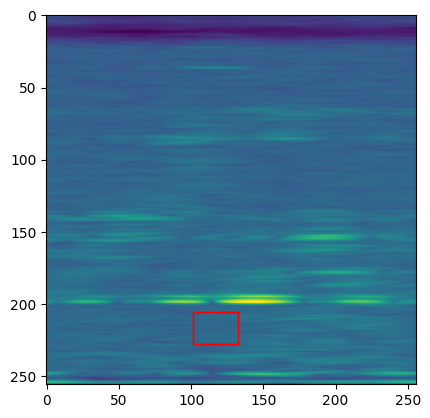

In [67]:
import matplotlib.patches as patches
from PIL import Image


fig, ax = plt.subplots()

ax.imshow(x)

# Create a Rectangle patch
for i in range(len(data[data.imageid == '000090'])):
    rect = patches.Rectangle((132.5, 227.5), 132.5-163.5, 227.5-249.5, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

# 

# سهير محمد مجدى

In [104]:
import torch
import torchvision

In [ ]:
class CusDat(torch.utils.data.Dataset):
    def __init__(delf, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype('float')
        img = Image.apen(".../kaggle/input/carrada/test/stereo_image/"+ image_name + ".jpg").convert('RGB')
        labels = torch.ones((boxes.shape[0]), dtype = torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return torchvision.transforms.ToTensor()(img), target

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# TensorFlow

In [ ]:
import tensorflow as tf

In [26]:
# parameters from Range-Azimuth-Doppler based Radar Object Detectionfor Dynamic Road Users paper 
parameters = {"global_mean_log" : 3.2438383, "global_max_log" : 10.0805629, "global_min_log" : 0.0, "global_variance_log" : 6.8367246, "designed_frequency" : 76.8,"config_frequency" : 77,"range_size" : 256,"doppler_size" : 64,"azimuth_size" : 256,"range_resolution" : 0.1953125,"angular_resolution" : 0.006135923,"velocity_resolution" : 0.41968030701528203}

In [ ]:
def gtfileFromRADfile(RAD_file, prefix):
    """ Transfer RAD filename to gt filename """
    RAD_file_spec = RAD_file.split("RAD")[-1]
    gt_file = os.path.join(prefix, "gt") + RAD_file_spec.replace("npy", "pickle")
    return gt_file
 
def imgfileFromRADfile(RAD_file, prefix):
    """ Transfer RAD filename to gt filename """
    RAD_file_spec = RAD_file.split("RAD")[-1]
    gt_file = os.path.join(prefix, "stereo_image") + RAD_file_spec.replace("npy", "jpg")
    return gt_file

def readRAD(filename):
    """ read input RAD matrices """
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None

def readRadarInstances(pickle_file):
    """ read output radar instances. """
    if os.path.exists(pickle_file):
        with open(pickle_file, "rb") as f:
            radar_instances = pickle.load(f)
        if len(radar_instances['classes']) == 0:
            radar_instances = None
    else:
        radar_instances = None
    return radar_instances
   
def readStereoLeft(img_filename):
    """ read stereo left image for verification. """
    if os.path.exists(img_filename):
        stereo_image = cv2.imread(img_filename)
        left_image = stereo_image[:, :stereo_image.shape[1]//2, ...][..., ::-1]
        return left_image
    else:
        return None
    
def readSingleImage(img_filename):
    """ read stereo left image for verification. """
    if os.path.exists(img_filename):
        image = cv2.imread(img_filename)
        image = image[..., ::-1]
        return image
    else:
        return None
   

all_RAD_files = glob(os.path.join('/kaggle/input/carrada/test/', "RAD/*/*.npy"))

for i in tqdm(range(len(all_RAD_files))):
    RAD_filename = all_RAD_files[i]
    process(
            RAD_filename=RAD_filename, frame_id = i, config_data=config_data, config_radar=config_radar, 
            colors=colors, fig=fig, 
            axes=axes, 
            interpolation=interpolation, 
            canvas_draw=canvas_draw)
    
    RAD = loader.readRAD(RAD_filename)
    gt_file = loader.gtfileFromRADfile(RAD_filename, prefix)
    gt_instances = loader.readRadarInstances(gt_file)
    img_file = loader.imgfileFromRADfile(RAD_filename, prefix)
    stereo_left_image = loader.readStereoLeft(img_file)

In [24]:
def normalization(file_name):
    RAD_data = np.load(file_name)
    RAD_complex = readRAD(RAD_filename)
    # normalize whole data
    RAD_data = complexTo2Channels(RAD_complex)
    normalized_RAD = (RAD_data - parameteres["global_mean_log"]) / parameteres["global_variance_log"]
    
    # return normalized data
    return normalized_RAD


def cartesian_to_polar(x, y):
    """ Cartesian to Polar """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def polar_to_cartesian(rho, phi):
    """ Polar to Cartesian """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def complexTo2Channels(target_array):
    """ transfer complex a + bi to [a, b]"""
    assert target_array.dtype == np.complex64
    ### NOTE: transfer complex to (magnitude) ###
    output_array = getMagnitude(target_array)
    output_array = getLog(output_array)
    return output_array

def getMagnitude(target_array, power_order=2):
    """ get magnitude out of complex number """
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array 

def getLog(target_array):
    """ get Log values """
    return  np.log10(target_array + 1.)


def getSumDim(target_array, target_axis):
    """ sum up one dimension """
    output = np.sum(target_array, axis=target_axis)
    return output

def extract_RA(file_name):
    RAD = normalization(file_name).T
    RA = np.log(np.absolute(RAD).sum(axis=0))
    return RA.T

def extract_RD(file_name):
    RAD = normalization(file_name)
    RD = np.log(np.absolute(RAD).sum(axis=0))
    return RD

def extract_DoA(file_name):
    RA = extract_RA(file_name) 
    return polar_to_cartesian(RA)

def readRAD(filename):
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None
    
RAD = readRAD('/kaggle/input/carrada/test/RAD/000156.npy')

RA = getLog(getSumDim(getMagnitude(RAD, power_order=2), target_axis=-1), scalar=10, log_10=True)
RD = getLog(getSumDim(getMagnitude(RAD, power_order=2), target_axis=1), scalar=10, log_10=True)

In [25]:
RA.shape

(256, 256)

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # pass normalization {RAD}, extract_DoA or extract_RA 
    validation_split = 0.2
)

# 

# 

# YoloV5

In [ ]:
! git clone https://github.com/ultralytics/yolov5.git
! cd yolov5
! pip install -r requirements.txt

In [ ]:
! python train.py --img 640 --batch 16 --epochs 50 --data data.yaml --cfg models/yolov5s.yaml --weights '' --name custom_dataset

In [ ]:
! python val.py --img 640 --data data.yaml --weights runs/train/custom_dataset/weights/best.pt

In [ ]:
! python train.py --img 640 --batch 16 --epochs 100 --data data.yaml --cfg models/yolov5s.yaml --weights runs/train/custom_dataset/weights/last.pt --name custom_dataset_ft